In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append("src/")
import gpt as g

from qcd_ml.nn.ptc import v_PTC
from qcd_ml.qcd.dirac import dirac_wilson_clover
from qcd_ml.base.paths import PathBuffer

from qcd_ml.compat.gpt import lattice2ndarray, ndarray2lattice

from qcd_ml.util.solver import GMRES_restarted
from qcd_ml.util.qcd.multigrid import ZPP_Multigrid

SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: pc1011901129
--------------------------------------------------------------------------
/home/knd35666/.local/lib/python3.12/site-packages/torch/_inductor/lowering.py:1612: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


In [3]:

def l2norm(v):
    return (v * v.conj()).real.sum()

In [6]:
GMRES_restarted?

Signature:
GMRES_restarted(
    A,
    b,
    x0,
    max_restart=10,
    maxiter_inner=100,
    eps=0.0001,
    regulate_b_norm=0.001,
    innerproduct=None,
    prec=None,
)
Docstring: <no docstring>
File:      ~/physics/ML/lattice_ML/reimplement_pytorch/qcd_ml/src/qcd_ml/util/solver.py
Type:      function

In [10]:
U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))

w = dirac_wilson_clover(U, -0.58, 1.0)

U_gpt = g.load("/home/knd35666/data/ensembles/ens_001/1500.config/")
w_gpt = g.qcd.fermion.wilson_clover(U_gpt, {"mass": -0.58,
    "csw_r": 1.0,
    "csw_t": 1.0,
    "xi_0": 1.0,
    "nu": 1.0,
    "isAnisotropic": False,
    "boundary_phases": [1,1,1,1]})

w = lambda x: torch.tensor(lattice2ndarray(w_gpt(ndarray2lattice(x.numpy(), U_gpt[0].grid, g.vspincolor))))

GPT :     454.959682 s : Reading /home/knd35666/data/ensembles/ens_001/1500.config/
GPT :     454.967077 s : Switching view to [1,1,1,1]/Read
GPT :     455.010993 s : Read 0.00109863 GB at 0.0250095 GB/s (0.0553487 GB/s for distribution, 0.0456364 GB/s for reading + checksum, 3.22013 GB/s for checksum, 1 views per node)
GPT :     455.025641 s : Read 0.00109863 GB at 0.0777105 GB/s (1.75677 GB/s for distribution, 0.0813272 GB/s for reading + checksum, 3.28908 GB/s for checksum, 1 views per node)
GPT :     455.039908 s : Read 0.00109863 GB at 0.0820016 GB/s (1.94759 GB/s for distribution, 0.0856251 GB/s for reading + checksum, 3.31034 GB/s for checksum, 1 views per node)
GPT :     455.053396 s : Read 0.00109863 GB at 0.0869024 GB/s (3.05368 GB/s for distribution, 0.0894688 GB/s for reading + checksum, 3.42348 GB/s for checksum, 1 views per node)
GPT :     455.054767 s : Completed reading /home/knd35666/data/ensembles/ens_001/1500.config/ in 0.0997429 s


In [68]:
psi = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)

n_basis = 12

bv = [torch.randn_like(psi) for _ in range(n_basis)]
#bv = orthonormalize(bv)
bv = [bi / l2norm(bi) for bi in bv]

In [74]:
mg_setup = ZPP_Multigrid.gen_from_fine_vectors(bv, [4, 4, 4, 4], lambda b, x0: GMRES_restarted(w, b, x0, eps=1e-4, maxiter_inner=25, max_restart=15))

In [16]:
vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
x, ret = GMRES_restarted(w, vec, vec, eps=1e-6, max_restart=500 // 20, maxiter_inner=30)
ret

{'converged': True, 'k': 661, 'res': tensor(9.9415e-05, dtype=torch.float64)}

In [75]:
w_coarse = mg_setup.get_coarse_operator(w)
b = vec
zero = torch.zeros_like(vec)
zero_coarse = mg_setup.v_project(zero)
b_coarse = mg_setup.v_project(b)

#def mg_prec(x):
#    print(">>", l2norm(w(x) - b))
#    x, ret = GMRES_restarted(w, b, x, eps=1e-4, max_restart=2, maxiter_inner=5, regulate_b_norm=1e-5)
#    
#    print(">", ret["res"])
#    x_coarse = mg_setup.v_project(x)
#    res_coarse = mg_setup.v_project(w(x) - b)
#    
#
#    x_coarse, ret_coarse = GMRES_restarted(w_coarse, zero_coarse, res_coarse, eps=1e-4, max_restart=2, maxiter_inner=15, regulate_b_norm=1e-5)
#    print("~", ret_coarse["res"])
#    x = x + mg_setup.v_prolong(x_coarse)
#
#    x, ret = GMRES_restarted(w, b, x, eps=1e-4, max_restart=2, maxiter_inner=5, regulate_b_norm=1e-5)
#    print("<", ret["res"])
#    print("<<", l2norm(w(x) - b))
#    return x

In [41]:
#x_p, ret_p = GMRES_restarted(w, vec, vec, eps=1e-6, max_restart=500 // 20, maxiter_inner=30, prec=mg_prec, regulate_b_norm=0)

>> tensor(99125.8486, dtype=torch.float64)
> tensor(0.0617, dtype=torch.float64)
~ tensor(3258.7907, dtype=torch.float64)
< tensor(0.0325, dtype=torch.float64)
<< tensor(102.9035, dtype=torch.float64)
>> tensor(96117.5001, dtype=torch.float64)
> tensor(0.0615, dtype=torch.float64)
~ tensor(3262.4172, dtype=torch.float64)
< tensor(0.0325, dtype=torch.float64)
<< tensor(102.7933, dtype=torch.float64)
>> tensor(97409.9573, dtype=torch.float64)
> tensor(0.0615, dtype=torch.float64)
~ tensor(3263.3784, dtype=torch.float64)
< tensor(0.0324, dtype=torch.float64)
<< tensor(102.0258, dtype=torch.float64)
>> tensor(97413.4350, dtype=torch.float64)
> tensor(0.0617, dtype=torch.float64)
~ tensor(3254.8238, dtype=torch.float64)
< tensor(0.0325, dtype=torch.float64)
<< tensor(102.6835, dtype=torch.float64)
>> tensor(97443.6590, dtype=torch.float64)
> tensor(0.0617, dtype=torch.float64)
~ tensor(3244.0561, dtype=torch.float64)
< tensor(0.0326, dtype=torch.float64)
<< tensor(103.2382, dtype=torch.floa

KeyboardInterrupt: 

In [62]:
def arnoldi_k(A, qprev, Hprev, k, innerproduct):
    if hasattr(A, "__call__"):
        qk = A(qprev[k-1])
    else:
        qk = A @ qprev[k-1]

    for j in range(k):
        Hprev[j, k-1] = innerproduct(qprev[j], qk)
        qk = qk - Hprev[j, k-1] * qprev[j]
    Hprev[k, k-1] = np.linalg.norm(qk)
    qk /= Hprev[k, k-1]
    qprev[k] = qk
    return qprev, Hprev

def arnoldi(A, n, q0, innerproduct=None):
    if n < 1:
        raise ValueError("nothing to do")

    if innerproduct is None:
        innerproduct = lambda x, y: torch.sum(torch.conj(x) * y)
    
    H = torch.zeros((n+1, n), dtype=torch.cdouble)
    # This is Q^T because the shape of the
    # vectors is not known.
    q = torch.zeros((n+1, *(q0.shape)), dtype=torch.cdouble)

    q[0] = q0

    for k in range(1, n+1):
        q, H = arnoldi_k(A, q, H, k, innerproduct)

    return q, H

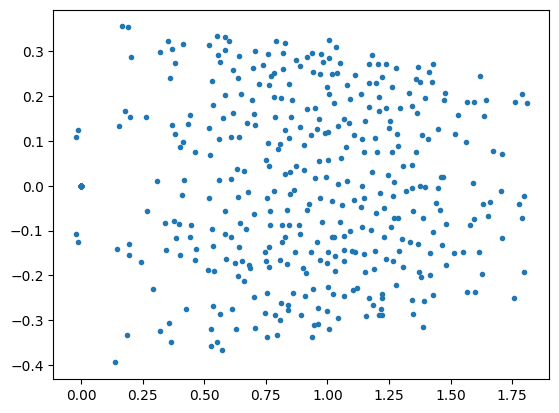

In [76]:

q, H = arnoldi(w_coarse, 500, b_coarse)
evals_coarse = np.linalg.eigvals(H[:-1])
plt.plot(evals_coarse.real, evals_coarse.imag, ".")

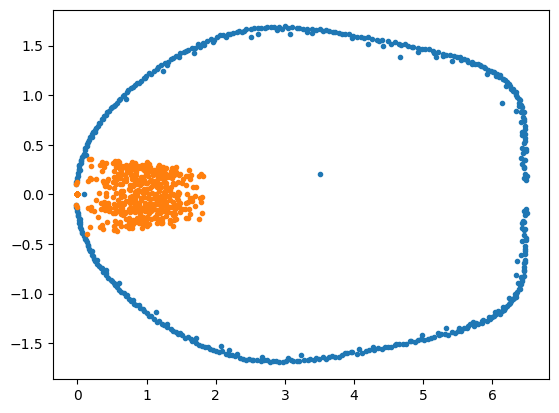

In [77]:
q, H = arnoldi(w, 500, b)
evals = np.linalg.eigvals(H[:-1])

plt.plot(evals.real, evals.imag, ".")
plt.plot(evals_coarse.real, evals_coarse.imag, ".")

(-0.5, 0.5)

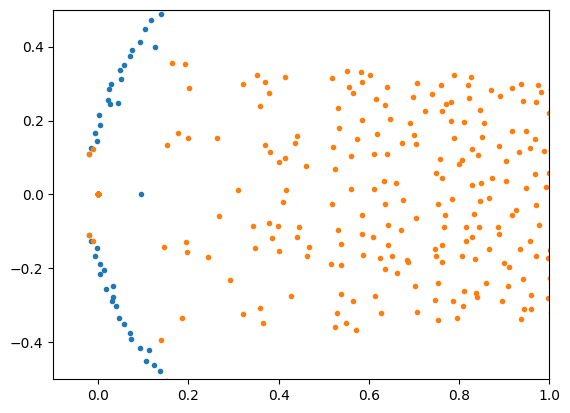

In [78]:
plt.plot(evals.real, evals.imag, ".")
plt.plot(evals_coarse.real, evals_coarse.imag, ".")
plt.xlim(-0.1, 1)
plt.ylim(-.5, .5)

In [79]:
mg_setup.save("mg_setup.pt")